## Bank Customer Churn 

In [1]:
# We import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

### EDA

In [2]:
# We import data
df = pd.read_csv('Bank_Customer_Churn_Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [6]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
df.drop(columns=['customer_id'], inplace=True)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns


### **Analysis of Numerical Features**

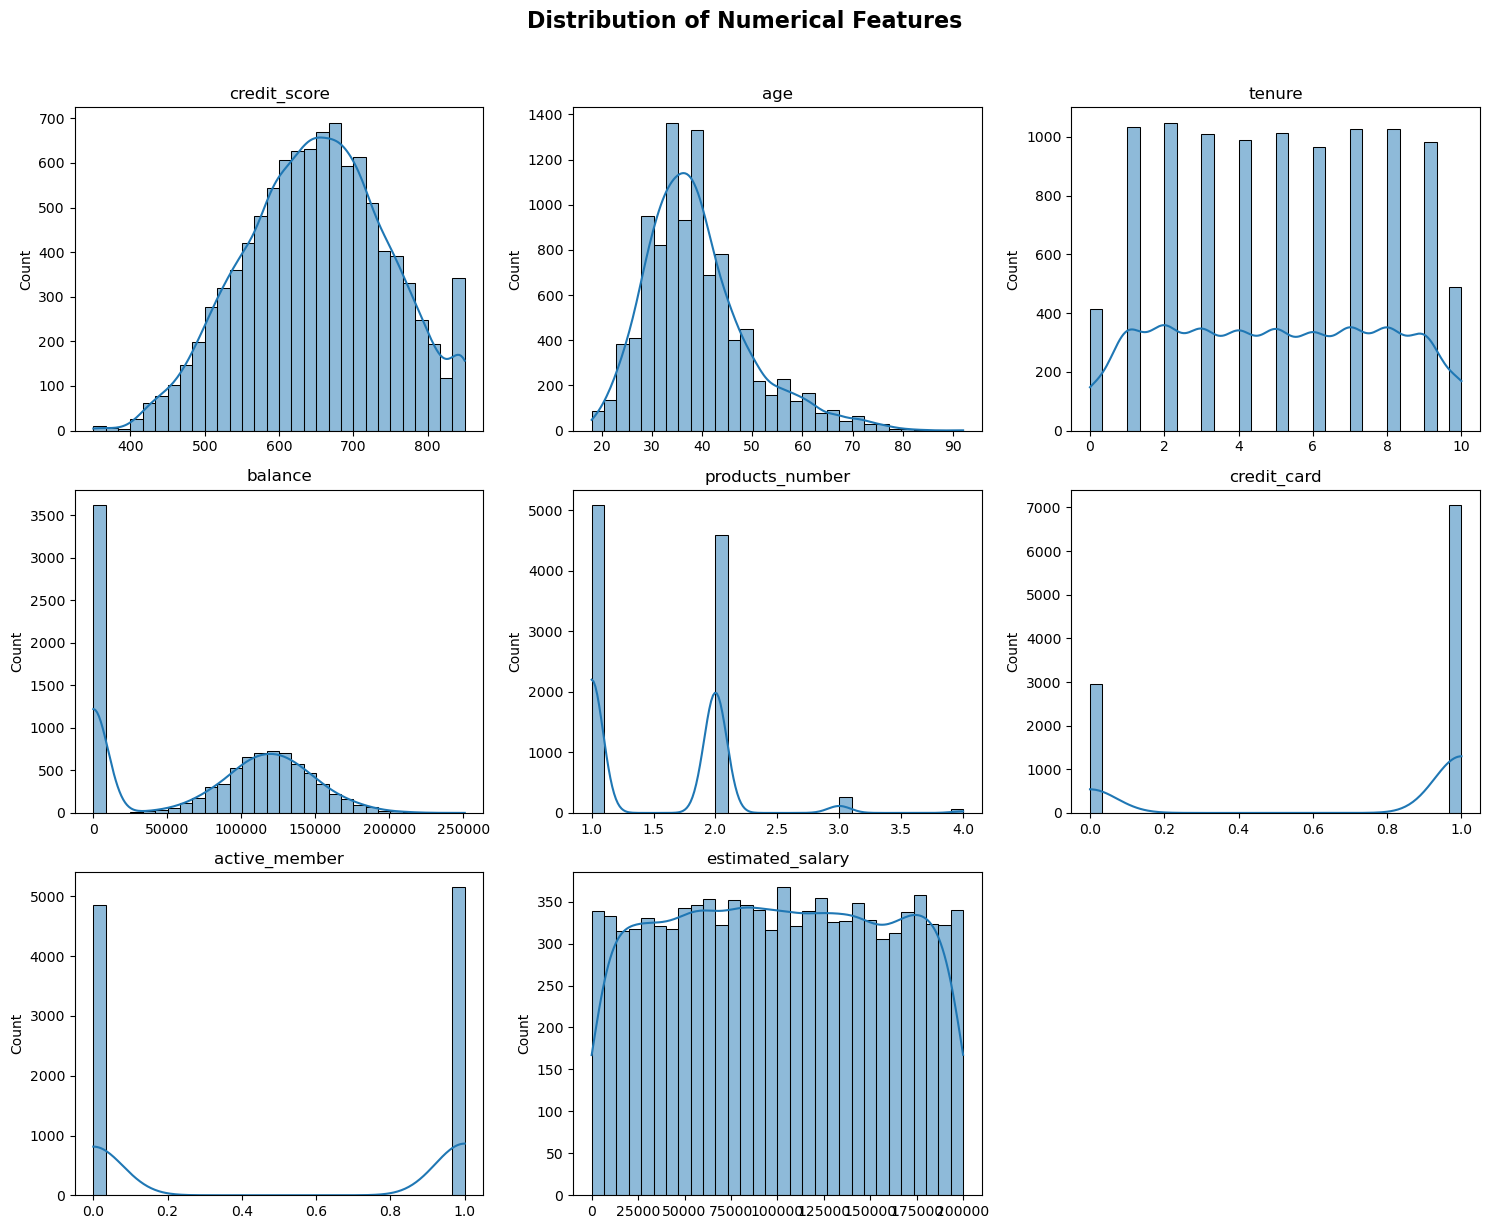

In [8]:
num_cols_plot = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'churn']

num_columns = 3  
num_rows = math.ceil(len(num_cols_plot) / num_columns) 
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 4 * num_rows))
axes = axes.flatten()  


for i, column in enumerate(num_cols_plot):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')

for i in range(len(num_cols_plot), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

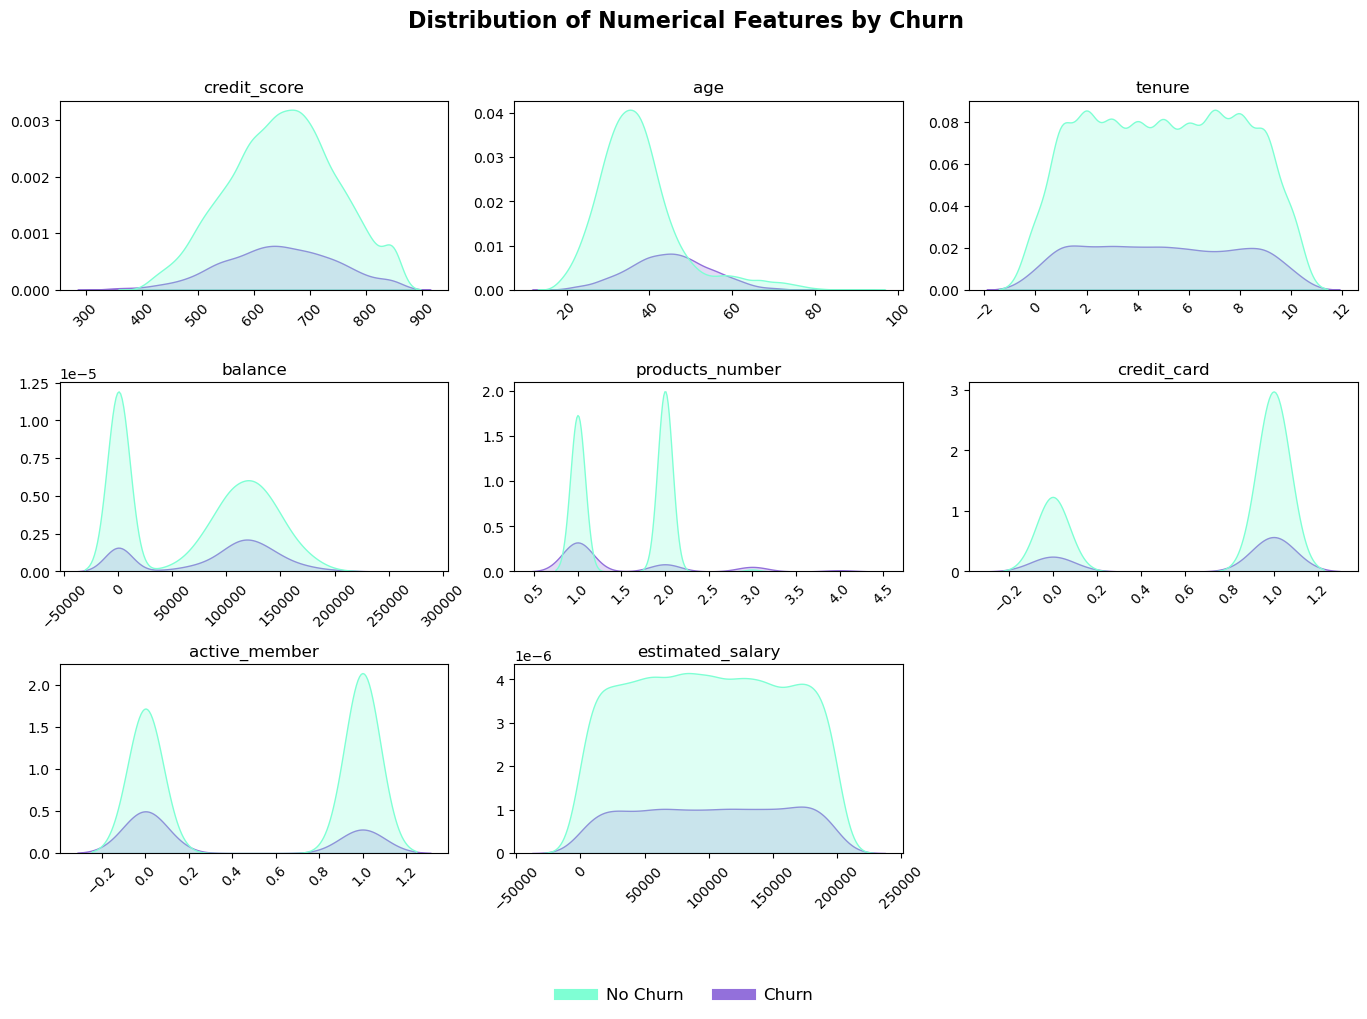

In [9]:
colors = {0: 'aquamarine', 1: 'mediumpurple'}
num_columns = 3
num_rows = math.ceil(len(num_cols_plot) / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(14, 3 * num_rows))
axes = axes.flatten()  

for i, column in enumerate(num_cols_plot):
    sns.kdeplot(data=df, x=column, hue='churn', palette=colors, fill=True, ax=axes[i], hue_order=[0, 1], legend=False) 
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)

for i in range(len(num_cols_plot), len(axes)):
    fig.delaxes(axes[i])

handles = [plt.Line2D([0], [0], color=colors[label], lw=8) for label in [0, 1]]
fig.legend(handles, ['No Churn', 'Churn'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='large', frameon=False)

plt.suptitle('Distribution of Numerical Features by Churn', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

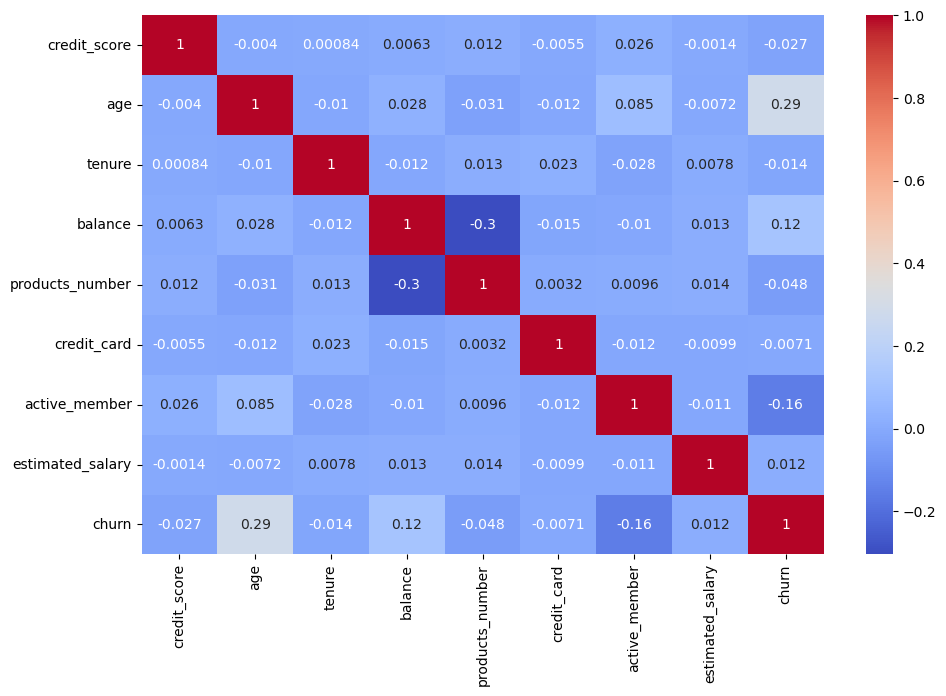

In [10]:
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(11, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

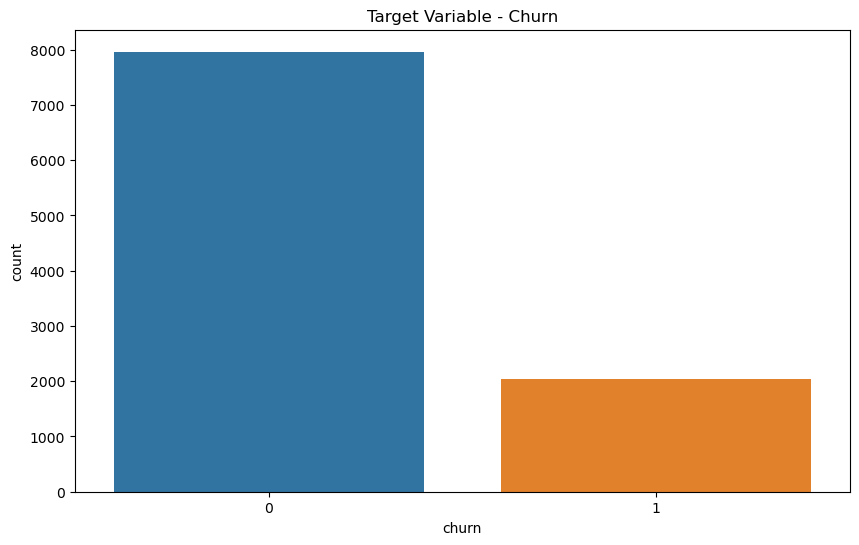

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='churn', data=df)
plt.title("Target Variable - Churn")
plt.show()


### **Analysis of Categorical Features**

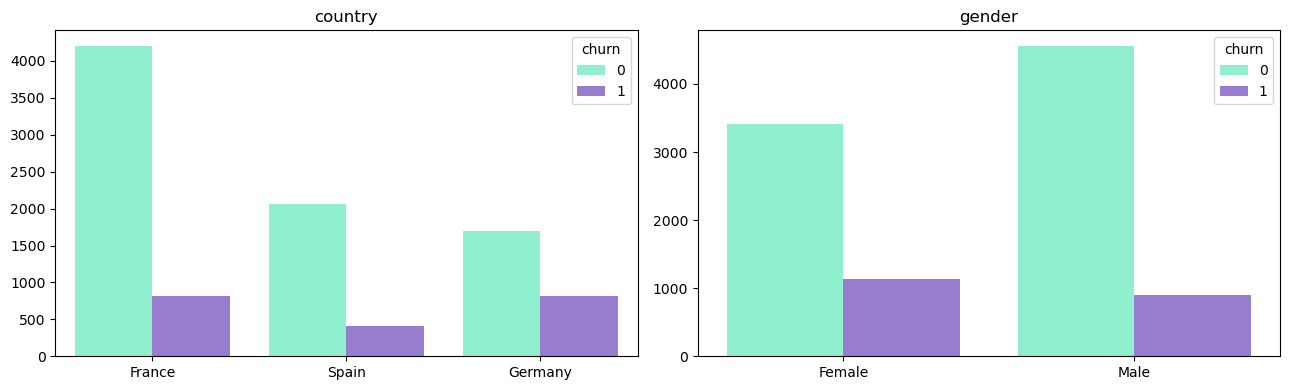

In [12]:
num_columns = 2
num_rows = math.ceil(len(cat_cols) / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(13, 4 * num_rows))
axes = axes.flatten() 

for i, column in enumerate(cat_cols):
    sns.countplot(data=df, x=column, hue='churn', palette={0: 'aquamarine', 1: 'mediumpurple'}, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

###  Encode and Scale Features. Split Data into Train and Test

In [13]:
# Encode Features 

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df_encoded= pd.concat([df[num_cols], df[cat_cols]], axis=1)

In [14]:
X = df_encoded.drop(columns=['churn'])
y = df_encoded['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Models

In [15]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.77      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000

Confusion Matrix:
[[1538   55]
 [ 227  180]]


In [16]:
#XGBoost

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_xgb))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.47      0.59       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000

Confusion Matrix:
[[1537   56]
 [ 214  193]]


In [17]:
# LightGBM

lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

lgbm_model.fit(X_train, y_train)

# Predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_lgbm)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_lgbm))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.74      0.49      0.59       407

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

Confusion Matrix:
[[1523   70]
 [ 209  198]]


In [18]:
# Results

results = {
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "XGBoost": accuracy_score(y_test, y_pred_xgb),
    "LightGBM": accuracy_score(y_test, y_pred_lgbm),
    }

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df["Accuracy"] = results_df["Accuracy"].apply(lambda x: round(x, 4))
results_df = results_df.sort_values(by="Accuracy", ascending=False)

results_df

,Model,Accuracy
1,XGBoost,0.8650
2,LightGBM,0.8605
0,Random Forest,0.8590


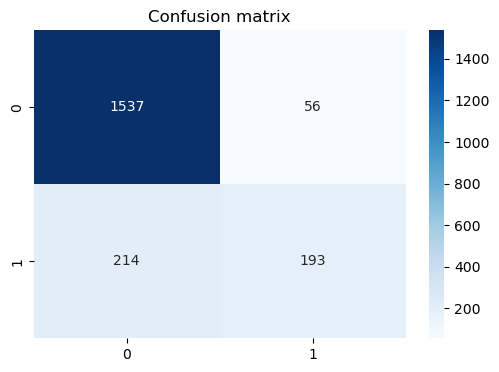

In [19]:
#Confusion matrix

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.show()


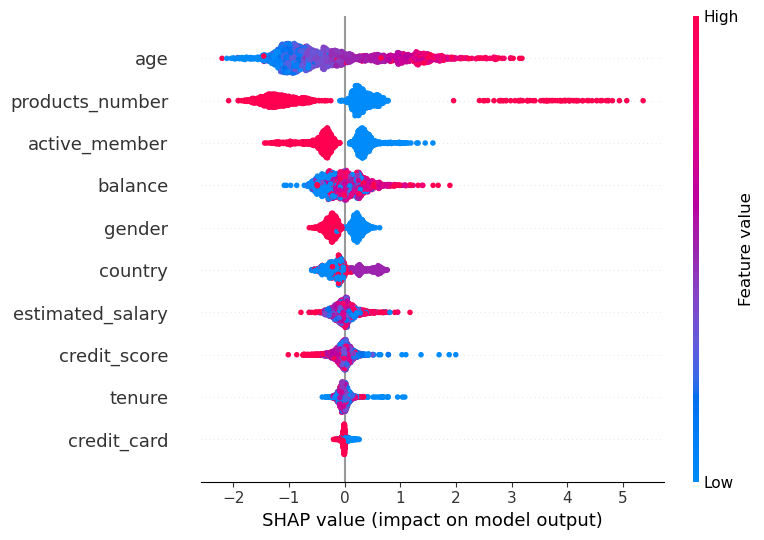

In [20]:
#  Feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)